# Importación de librerías 🐍

In [9]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Herramientas para el preprocesamiento del texto
import re
import nltk
nltk.download("stopwords")
from nltk.tokenize import regexp_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")
from nltk.corpus import stopwords
spanish_sw = set(stopwords.words("english"))

# Vectorizaciones basadas en BoW
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modelos "clásicos" de ML
from sklearn.naive_bayes import ComplementNB, \
    BernoulliNB  # BoW con pesado binario
from sklearn.svm import LinearSVC

# Modelos de DL
import tensorflow as tf

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wrstdani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wrstdani/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/wrstdani/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


# Clasificación de ideologías de tuits 🐦

## Carga de datos 💾

In [10]:
"""
- Definimos la ruta en que se encuentran nuestros datos y cargamos los DFs necesarios
"""
data_path = os.path.join("..", "data")
generated_path = os.path.join("..", "resources", "generated")

train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
dev_df = pd.read_csv(os.path.join(data_path, "development.csv"))

In [11]:
train_df.head()

,id,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,37732,@user239,female,politician,right,moderate_right,"@user, propuestas de futuro 💪#no tocar las ref..."
1,38447,@user13,female,journalist,left,left,@user @user Podemos entrar en bucle hasta el i...
2,10758,@user8,female,politician,left,moderate_left,👉🏻Como gallega me produce profunda decepción v...
3,33860,@user262,male,politician,right,right,"Y ahora, tras este raro de amable discusión so..."
4,11677,@user341,female,politician,right,right,1-No se trata de defender o no la labor de @us...


In [12]:
dev_df.head()

,id,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,14755,@user206,female,journalist,left,moderate_left,En unos minutos adelantaremos en @user imágene...
1,31904,@user137,female,politician,left,moderate_left,"Vacunar, vacunar y vacunar. Ese es el gran obj..."
2,45517,@user180,male,journalist,right,moderate_right,Me voy para @user. Hoy no hay programa pero es...
3,11015,@user290,male,politician,left,left,Vivimos en un país en el 12 mill y medio de pe...
4,25991,@user228,male,politician,right,moderate_right,En casa de la VP Rivera no les gusta q se habl...


In [13]:
"""
- Extraemos las etiquetas (labels) para la clasificación y los tuits
"""
labels = {
    "moderate_left": 0,
    "left": 1,
    "moderate_right": 2,
    "right": 3
}

print("- Etiquetas:")
print(f"    - Existen {len(labels)} clases:")
for l, i in labels.items():
    print(f"        - {l} -> {i}")

corpus_train = train_df["tweet"].tolist()
y_train = np.array([labels[l] for l in train_df["ideology_multiclass"]], dtype=np.uint8)
corpus_dev = dev_df["tweet"].tolist()
y_dev = np.array([labels[l] for l in dev_df["ideology_multiclass"]], dtype=np.uint8)

print("- Conjuntos de datos:")
print("    - Entrenamiento:")
print(f"        - {y_train.shape[0]} ejemplos.")
print("    - Desarrollo (Test):")
print(f"        - {y_dev.shape[0]} ejemplos.")

- Etiquetas:
    - Existen 4 clases:
        - moderate_left -> 0
        - left -> 1
        - moderate_right -> 2
        - right -> 3
- Conjuntos de datos:
    - Entrenamiento:
        - 28065 ejemplos.
    - Desarrollo (Test):
        - 4678 ejemplos.


## Visualización y preprocesamiento de los datos 🔍

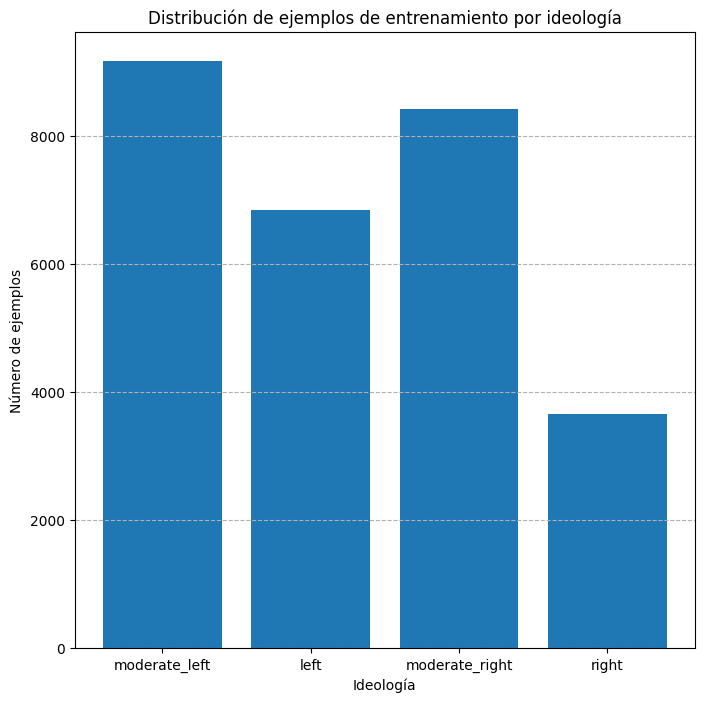

In [14]:
"""
- Histograma del número de ejemplos de cada clase
"""
filename = "train_classes_hist.png"
save_flag = True

class_names = list(labels.keys())
num_classes = len(class_names)

plt.figure(figsize=(8, 8))
plt.hist(y_train, bins=np.arange(num_classes + 1) - 0.5, rwidth=0.8, align='mid')

plt.title("Distribución de ejemplos de entrenamiento por ideología")
plt.xlabel("Ideología")
plt.ylabel("Número de ejemplos")

plt.xticks(ticks=np.arange(num_classes), labels=class_names)

plt.grid(axis='y', linestyle='--') # Añadir rejilla horizontal para facilitar la lectura

if save_flag:
    plt.savefig(os.path.join(generated_path, filename))

plt.show()

In [15]:
def nltk2wn_tag(tag: str) -> str:
    if tag.startswith("N"):
        return "n"
    elif tag.startswith("V"):
        return "v"
    elif tag.startswith("J"):
        return "a"
    elif tag.startswith("R"):
        return "r"
    else:
        return "n"

def preprocess_text_nltk(text: str, del_sw: bool = False, lem: bool = False) -> list[str]:
    """
    - Utilizando regex:
        - Eliminamos puntuación
        - Eliminamos menciones a usuarios (comienzan por "@")
    """
    preprocessed = text
    regex_mentions = r"@\w+\s*"
    preprocessed = re.sub(regex_mentions, "", preprocessed + " ")

    regex = r"\w{3,}"  # Tokens de 3 o más caracteres
    preprocessed = regexp_tokenize(preprocessed, regex)

    if del_sw:
        preprocessed = [w.lower() for w in preprocessed if w not in spanish_sw]

    if lem:
        preprocessed = [WordNetLemmatizer().lemmatize(w) for w in preprocessed]

    return " ".join(preprocessed)

sample = random.choice(corpus_train)
print("- Texto original:")
print(f"    - '{sample}'")
preprocessed_sample = preprocess_text_nltk(sample, True, True)
print("- Texto preprocesado:")
print(f"    - '{preprocessed_sample}'")

- Texto original:
    - 'Iglesias en el Consejo Estatal de Podemos: . “Creo que podemos estar muy orgullosos y orgullosas” de la gestión de la crisis. Me parece frívolo y de poca catadura moral con: . 40.000 fallecidos, 51.000 sanitarios contagiados, 1 MM de personas más en paro y 800.000 afiliados menos'
- Texto preprocesado:
    - 'iglesias consejo estatal podemos creo que podemos estar muy orgullosos orgullosas gestión crisis parece frívolo poca catadura moral con 000 fallecidos 000 sanitarios contagiados persona más paro 800 000 afiliados menos'
